In [1]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [3]:
EPOCHS =20
INIT_LR = 1e-3
BS = 15
default_image_size = tuple((256, 256))
image_size = 0
width=256
height=256
depth=3
train_dir=r"C:\Users\Glau\Desktop\DP\Pediastrum_cnn\Train"
valid_dir=r"C:\Users\Glau\Desktop\DP\Pediastrum_cnn\Test"
train_folder=listdir(train_dir)
valid_folder=listdir(valid_dir)

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
callbacks = MyCustomCallback()

In [6]:
train_image_list, train_image_label= [], []
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".TIFF") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing Lacunastrum gracilimum ...
processing Monactinus simplex ...
processing Parapediastrum biradiatum ...
processing Pediastrum angulosum ...
processing Pediastrum duplex ...
processing Pseudopediastrum boryanum ...
processing Stauridium tetras ...
[INFO] Image loading completed


In [7]:
print(len(train_image_label))

33600


In [8]:
valid_image_list, valid_image_label= [], []
for disease_folder in valid_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{valid_dir}/{disease_folder}")
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]: 
        image_directory = f"{valid_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".TIFF") == True:
            valid_image_list.append(convert_image_to_array(image_directory))
            valid_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing Lacunastrum gracilimum ...
processing Monactinus simplex ...
processing Parapediastrum biradiatum ...
processing Pediastrum angulosum ...
processing Pediastrum duplex ...
processing Pseudopediastrum boryanum ...
processing Stauridium tetras ...
[INFO] Image loading completed


In [9]:
print(len(valid_image_label))

8400


In [10]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_ped123.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [11]:
print(n_classes)

7


In [12]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0
np_valid_image_list = np.array(valid_image_list, dtype=np.float32) / 255.0

In [14]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [20]:
# coding: utf8
from tensorflow.keras import layers
from tensorflow.keras import models


#
# image dimensions
#

img_height = 256
img_width = 256
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 64, 128, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 128, 256, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(7,activation='softmax')(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_549 (Conv2D)             (None, 128, 128, 256 19456       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 128, 128, 256 1024        conv2d_549[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_49 (LeakyReLU)      (None, 128, 128, 256 0           batch_normalization_53[0][0]     
____________________________________________________________________________________________

lambda_810 (Lambda)             (None, 16, 16, 8)    0           leaky_re_lu_77[0][0]             
__________________________________________________________________________________________________
lambda_811 (Lambda)             (None, 16, 16, 8)    0           leaky_re_lu_77[0][0]             
__________________________________________________________________________________________________
lambda_812 (Lambda)             (None, 16, 16, 8)    0           leaky_re_lu_77[0][0]             
__________________________________________________________________________________________________
lambda_813 (Lambda)             (None, 16, 16, 8)    0           leaky_re_lu_77[0][0]             
__________________________________________________________________________________________________
lambda_814 (Lambda)             (None, 16, 16, 8)    0           leaky_re_lu_77[0][0]             
__________________________________________________________________________________________________
lambda_815

In [21]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")


[INFO] training network...


In [22]:
history=model.fit(np_train_image_list,bin_train_image_labels,
                  validation_data=(np_valid_image_list, bin_valid_image_labels),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 656s 20ms/sample - loss: 0.2356 - accuracy: 0.9250 - val_loss: 0.3472 - val_accuracy: 0.9777
Epoch 2/20
33600/33600 [==============================] - 613s 18ms/sample - loss: 0.0454 - accuracy: 0.9876 - val_loss: 0.3884 - val_accuracy: 0.9845
Epoch 3/20
33600/33600 [==============================] - 611s 18ms/sample - loss: 0.0152 - accuracy: 0.9959 - val_loss: 0.4105 - val_accuracy: 0.9845
Epoch 4/20
33600/33600 [==============================] - 612s 18ms/sample - loss: 0.0178 - accuracy: 0.9959 - val_loss: 0.4041 - val_accuracy: 0.9845
Epoch 5/20
33600/33600 [==============================] - 611s 18ms/sample - loss: 0.0177 - accuracy: 0.9952 - val_loss: 0.3676 - val_accuracy: 0.9844
Epoch 6/20
33600/33600 [==============================] - 611s 18ms/sample - loss: 0.0081 - accuracy: 0.9976 - val_loss: 0.4271 - val_accuracy: 0.9845
Epoch 7/20
33600/33600 [=====================

In [23]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(np_valid_image_list, bin_valid_image_labels)
print(f"Test Accuracy: {scores[1]*100}")


[INFO] Calculating model accuracy
8400/8400 [==============================] - 41s 5ms/sample - loss: 0.5652 - accuracy: 0.9845
Test Accuracy: 98.45238327980042


In [24]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(np_valid_image_list, bin_valid_image_labels)
print(f" std Test Accuracy: numpy.std{scores[1]*100}")

[INFO] Calculating model accuracy
8400/8400 [==============================] - 34s 4ms/sample - loss: 0.5652 - accuracy: 0.9845
 std Test Accuracy: numpy.std98.45238327980042


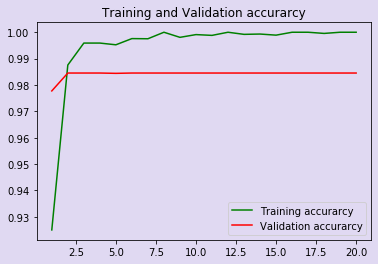

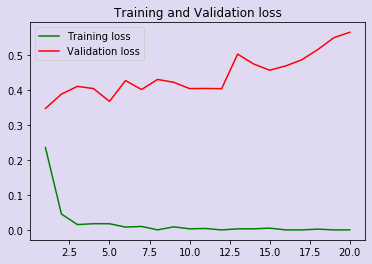

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [26]:
ycalculated = model.predict(np_valid_image_list)

In [27]:
print(np_valid_image_list)

[[[[1.         0.99607843 0.95686275]
   [1.         0.99607843 0.95686275]
   [1.         0.99607843 0.95686275]
   ...
   [1.         1.         0.9764706 ]
   [1.         1.         0.9764706 ]
   [1.         1.         0.9764706 ]]

  [[1.         0.99607843 0.95686275]
   [1.         0.99607843 0.95686275]
   [1.         0.99607843 0.95686275]
   ...
   [1.         1.         0.9764706 ]
   [1.         1.         0.9764706 ]
   [1.         1.         0.9764706 ]]

  [[1.         0.99607843 0.95686275]
   [1.         0.99607843 0.95686275]
   [1.         0.99607843 0.95686275]
   ...
   [1.         1.         0.9764706 ]
   [1.         1.         0.9764706 ]
   [1.         1.         0.9764706 ]]

  ...

  [[1.         1.         0.9529412 ]
   [1.         1.         0.9529412 ]
   [1.         1.         0.9529412 ]
   ...
   [1.         1.         0.98039216]
   [1.         1.         0.98039216]
   [1.         1.         0.98039216]]

  [[1.         1.         0.9529412 ]
   [1. 

In [28]:
yhat_classes =np.argmax(ycalculated,axis=1)


In [29]:
import numpy as np
rounded_labels=np.argmax(bin_valid_image_labels,axis=1)


In [30]:
print(label_binarizer.classes_)

['Lacunastrum gracilimum' 'Monactinus simplex' 'Parapediastrum biradiatum'
 'Pediastrum angulosum' 'Pediastrum duplex' 'Pseudopediastrum boryanum'
 'Stauridium tetras']


In [31]:
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
#import seaborn as sns
#y_pred=model.predict_classes(np_valid_image_list)
#con_mat = tf.math.confusion_matrix(labels=y_true, predictions=ycalculated).numpy()
#matrix = confusion_matrix(rounded_labels,yhat_classes)
#y_pred=model.predict(np.array(val_image_list))
#yhat_classes = ["honda", "chevrolet", "honda", "toyota", "toyota", "chevrolet"]
#rounded_labels = ["honda", "chevrolet", "honda", "toyota", "toyota", "honda"]
cm =confusion_matrix(rounded_labels,yhat_classes)  

#matrix =confusion_matrix(bin_val_image_labels.argmax(axis=1), ycalculated)
#print(matrix)

In [32]:
print(cm)


[[1170   30    0    0    0    0    0]
 [  30 1170    0    0    0    0    0]
 [   0    0 1170    0    0   15   15]
 [   0    0    0 1200    0    0    0]
 [   0    0    0    0 1200    0    0]
 [   0    0   25    0    0 1175    0]
 [   0    0    5    0    0   10 1185]]


In [33]:

from sklearn.metrics import accuracy_score,classification_report 
target_names = ['Lacunastrum ', 'Monactinus', 'Parapediastrum','Pediastrum ','Pediastrum','Pseudopediastrum','Stauridium']
print(classification_report(rounded_labels, yhat_classes, target_names=target_names))


                  precision    recall  f1-score   support

    Lacunastrum        0.97      0.97      0.97      1200
      Monactinus       0.97      0.97      0.97      1200
  Parapediastrum       0.97      0.97      0.97      1200
     Pediastrum        1.00      1.00      1.00      1200
      Pediastrum       1.00      1.00      1.00      1200
Pseudopediastrum       0.98      0.98      0.98      1200
      Stauridium       0.99      0.99      0.99      1200

        accuracy                           0.98      8400
       macro avg       0.98      0.98      0.98      8400
    weighted avg       0.98      0.98      0.98      8400



Text(0.5, 1, 'Heat map Matrix')

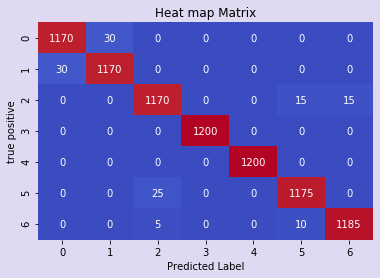

In [34]:
import seaborn as sns
#cmap = sns.cubehelix_palette(light=1, as_cmap=True)

bg_color = (0.88,0.85,0.95)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color
sns.heatmap(cm,annot=True,cbar=False,fmt="d",annot_kws={'size':10},cmap='coolwarm')
#res.invert_yaxis()

#plt.yticks([0.5,1.5,2.5], [ 'Dog', 'Cat', 'Rabbit'],va='center')

plt.ylabel('true positive')
plt.xlabel('Predicted Label')
plt.title('Heat map Matrix')

In [35]:
accuracy = accuracy_score(rounded_labels,yhat_classes)
print('Accuracy: %f' % accuracy)

Accuracy: 0.984524


In [36]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test= lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
multiclass_roc_auc_score(rounded_labels,yhat_classes)

0.9909722222222224

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


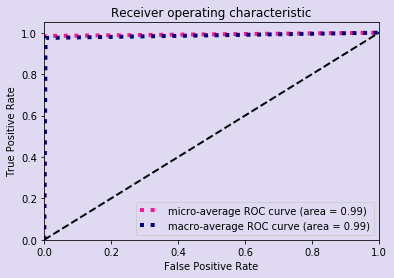

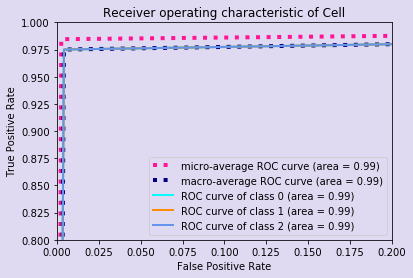

In [37]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes =3

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
lb = LabelBinarizer()
lb.fit(rounded_labels)
y_test= lb.transform(rounded_labels)
snn_pred = lb.transform(yhat_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,color='white')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Cell')
plt.legend(loc="lower right")
plt.show()



In [38]:
model.save("model_ped123.h5")

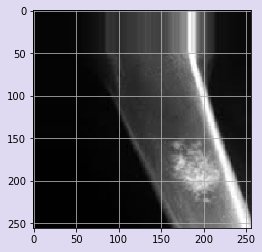

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
#img = x_test[13]
img = load_img(r"C:\Users\Glau\Desktop\DP\cancer_1.jpg", target_size=(256, 256))
plt.imshow(img)
plt.grid(True)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)


In [50]:
classifier = load_model("model_ped123.h5")

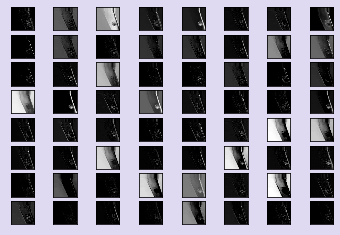

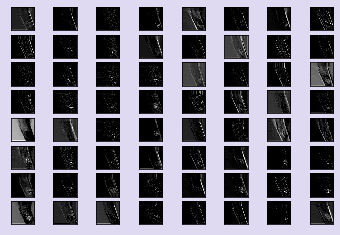

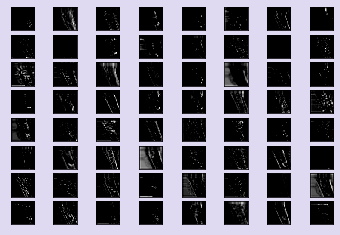

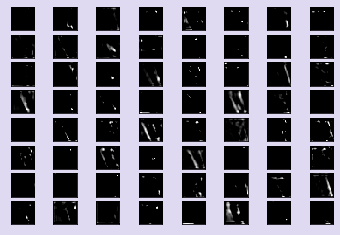

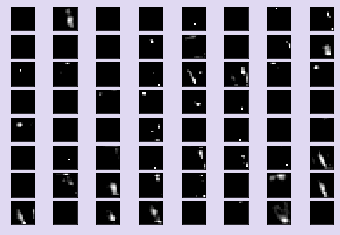

In [53]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img(r"C:\Users\Glau\Desktop\DP\cancer_1.jpg", target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()

In [39]:
model = load_model("model_cancer_New12.h5")